In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from itertools import repeat
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

In [2]:
def conv(s):
    if s == '':
        return np.nan
    return float(s.replace(',', '.'))

columns_to_conv = ['Нефть, т', 'Конденсат, т', 'Приемистость, м3/сут', 'Обводненность (вес), %', 'Нефть, м3', 'Жидкость, м3', \
                    'Дебит конденсата', 'Добыча растворенного газа, м3', 'Дебит попутного газа, м3/сут']
convertors = dict(zip(columns_to_conv, repeat(conv.__call__, len(columns_to_conv))))

def conv_date(x):
    if x.day != 1:
        return (x + pd.offsets.MonthBegin(1))
    else:
        return x

### Загружаем данные

In [3]:
df_train = pd.read_csv('init/1/train_1.8.csv', header = 0 ,encoding = 'cp1251', parse_dates = ['Дата'], converters= convertors)
df_test = pd.read_csv('init/1/test_1.9.csv', header = 0 ,encoding = 'cp1251', parse_dates = ['Дата'], converters= convertors)

df_coord_train = pd.read_csv('init/1/coords_train_1.1.csv', header = 0,encoding = 'cp1251')
df_coord_test = pd.read_csv('init/1/coords_test_1.1.csv', header = 0,encoding = 'cp1251')
df_coord_train = df_coord_train.rename(columns={'well_hash' : 'Скважина'})
df_coord_test = df_coord_test.rename(columns={'well_hash' : 'Скважина'})

df_frac_train = pd.read_csv('init/1/frac_train_1.csv', header = 0,encoding = 'cp1251')
df_frac_test = pd.read_csv('init/1/frac_test_1.csv', header = 0,encoding = 'cp1251')

df_gdis_train = pd.read_csv('init/1/gdis_train1.2.csv', header = 0,encoding = 'cp1251')
df_gdis_test = pd.read_csv('init/1/gdis_test1.2.csv', header = 0,encoding = 'cp1251')
df_gdis_train_gr = df_gdis_train.groupby('Скважина').mean().reset_index()
df_gdis_test_gr = df_gdis_test.groupby('Скважина').mean().reset_index()

### Центруем координаты (может и не надо)

In [4]:
df_coord_train['x'] = df_coord_train['ПЛАСТ_X'].astype(dtype='int32')
df_coord_train['y'] = df_coord_train['ПЛАСТ_Y'].astype(dtype='int32')
df_coord_train['x'] = df_coord_train['x'] - df_coord_train['x'].mean()
df_coord_train['y'] = df_coord_train['y'] - df_coord_train['y'].mean()

df_coord_train['x_head'] = df_coord_train['УСТЬЕ_X'].astype(dtype='int32')
df_coord_train['y_head'] = df_coord_train['УСТЬЕ_Y'].astype(dtype='int32')
df_coord_train['x_head'] = df_coord_train['x_head'] - df_coord_train['x_head'].mean()
df_coord_train['x_head'] = df_coord_train['x_head'] - df_coord_train['x_head'].mean()

In [ ]:
%matplotlib notebook
plt.figure(figsize=(10,10))
plt.scatter(df_coord_train.drop_duplicates('well_hash', 'first')['ПЛАСТ_X'], 
            df_coord_train.drop_duplicates('well_hash', 'first')['ПЛАСТ_Y'], color = 'g', label='train')
plt.scatter(df_coord_test.drop_duplicates('well_hash', 'first')['ПЛАСТ_X'], 
            df_coord_test.drop_duplicates('well_hash', 'first')['ПЛАСТ_Y'], color = 'r', label='test')
plt.legend()

In [6]:
w_coord_train = df_coord_train['Скважина'].unique()
w_coord_test = df_coord_test['Скважина'].unique()
w_train = df_train['Скважина'].unique()
w_test = df_test['Скважина'].unique()
w_frac_train = df_frac_train['Скважина'].unique()
w_frac_test = df_frac_test['Скважина'].unique()
w_gdis_train = df_gdis_train['Скважина'].unique()
w_gdis_test = df_gdis_test['Скважина'].unique()

In [7]:
print('# of wells in train: ', len(w_train))
print('# of wells in coord train: ', len(w_coord_train))
print('# of wells intersect train and coord train: ', len(list(set(w_train) & set(w_coord_train))))
print('# of wells in frac train: ', len(w_frac_train))
print('# of wells in gdis train: ', len(w_gdis_train))

# of wells in train:  563
# of wells in coord train:  234
# of wells intersect train and coord train:  233
# of wells in frac train:  490
# of wells in gdis train:  388


In [8]:
print('# of wells in test: ', len(w_test))
print('# of wells in coord test: ', len(w_coord_test))
print('# of wells in frac test: ', len(w_frac_test))
print('# of wells in gdis test: ', len(w_gdis_test))

# of wells in test:  266
# of wells in coord test:  137
# of wells in frac test:  193
# of wells in gdis test:  106


### Рассчитаем нужные свойства и объединим стобцы

In [9]:
df_train.loc[:, 'Дата'] = df_train['Дата'].apply(conv_date)

df_train['days_on'] = df_train['Время работы, ч']/24

df_train['oil_rate'] = df_train['Нефть, м3']/(df_train['Время работы, ч']/24)

df_train['oil_prod'] = df_train['Нефть, т']

df_train['liq_rate'] = df_train['Жидкость, м3']/(df_train['Время работы, ч']/24)

df_train.loc[df_train['liq_rate'].isnull(), 'liq_rate'] = df_train[df_train['liq_rate'].isnull()]['Дебит жидкости']

df_train.loc[df_train['oil_rate'].isnull(), 'oil_rate'] = df_train[df_train['oil_rate'].isnull()]['liq_rate'] \
                                                            *(1-df_train[df_train['oil_rate'].isnull()]['Обводненность']/100)

df_train['wct'] = 1 - df_train['Нефть, м3']/df_train['Жидкость, м3']
df_train.loc[df_train['wct'].isnull(), 'wct'] = df_train.loc[df_train['wct'].isnull(), 'Обводненность']/100

df_train['gas_rate'] = df_train['Попутный газ, м3']/(df_train['Время работы, ч']/24)
df_train.loc[df_train['gas_rate'].isnull(), 'gas_rate'] = df_train[df_train['gas_rate'].isnull()]['Газовый фактор']* \
                                                           df_train[df_train['gas_rate'].isnull()]['oil_rate'] 

df_train['gas_prod'] = df_train['Попутный газ, м3']

df_train['gf'] = df_train['Попутный газ, м3']/df_train['Нефть, т']
df_train.loc[df_train['gf'].isnull(), 'gf'] = df_train[df_train['gf'].isnull()]['Газовый фактор']

df_train['state'] = df_train['Состояние']
df_train.loc[df_train['state'].isnull(), 'state'] = df_train.loc[df_train['state'].isnull(), 'Состояние на конец месяца'] 

df_train['frac'] = df_train['Скважина'].apply(lambda x: x in df_frac_train['Скважина'].values).astype(int)

In [11]:
cols_of_interest = ['Скважина', 'Дата', 'liq_rate', 'oil_rate', 'wct', 'gas_rate', \
                    'gf', 'gas_prod', 'days_on', 'oil_prod', 'frac']
#df_train[['Скважина', 'Дата', 'liq_rate', 'oil_rate', 'wct', 'gas_rate', 'gf','Жидкость, м3', 'Нефть, м3', 'Время работы, ч', 'Дебит жидкости', 'Обводненность']]

### Объединим все

In [25]:
df_all_train = df_train[cols_of_interest].set_index('Скважина'). \
                join(df_gdis_train_gr.set_index('Скважина')). \
                join(df_coord_train[['Скважина', 'ПЛАСТ_X', 'ПЛАСТ_Y']].set_index('Скважина')).reset_index()

In [26]:
df_all_train.head()

,Скважина,Дата,liq_rate,oil_rate,wct,gas_rate,gf,gas_prod,days_on,oil_prod,frac,Давление пластовое,ПЛАСТ_X,ПЛАСТ_Y
0,005642f48d3e86d871bb701bac2ba042,2005-06-01,29.777778,29.722222,0.001866,1642.666667,64.0,29568.0,18.0,462.0,1,103.15,NaN,NaN
1,005642f48d3e86d871bb701bac2ba042,2005-07-01,6.290323,6.290323,0.000000,350.967742,64.0,10880.0,31.0,170.0,1,103.15,NaN,NaN
2,005642f48d3e86d871bb701bac2ba042,2005-08-01,5.366667,5.366667,0.000000,298.666667,64.0,8960.0,30.0,140.0,1,103.15,NaN,NaN
3,005642f48d3e86d871bb701bac2ba042,2005-09-01,5.500000,5.500000,0.000000,305.230769,64.0,7936.0,26.0,124.0,1,103.15,NaN,NaN
4,005642f48d3e86d871bb701bac2ba042,2005-10-01,9.733333,9.733333,0.000000,541.866667,64.0,16256.0,30.0,254.0,1,103.15,NaN,NaN


### Приведем данные к единому виду:
    Чтобы все скважины имели ненулевой дебит в первом месяце и работали 6 месяцев.
    Для этого убираем первые месяца, когда некоторые скважины имеют нулевую добычу. Дописываем им занчения фичей до 6-ти месяев согласно предыдущим значениям.
    

In [28]:
df_train_temp = df_train[cols_of_interest]
#df_train_temp.loc[:,'Дата'] = df_train_temp['Дата'].asfreq('M')


wells_start = df_train_temp[df_train_temp['liq_rate'].isnull()]['Скважина'].unique().tolist()

AttributeError_wells = []
ValueError_wells = []
for well in wells_start:
#well = 'a2d46cb2c0cce62767b4cd7dacc28d1e'
    df_well_train = df_train_temp[df_train_temp['Скважина'] == well].set_index('Дата')
    #df_well_train.index.rename('Дата', inplace=True)
    start_index = df_well_train['liq_rate'].first_valid_index()
    try:
        m_shift = start_index.to_period('M') - df_well_train.first_valid_index().to_period('M')
        last_index = pd.Timestamp(df_well_train.last_valid_index(), freq = 'MS') + m_shift
    
        df_train_temp.loc[df_train_temp['Скважина'] == well, :] = df_well_train.reindex(index = pd.date_range(start_index, last_index, freq = 'MS')). \
                                        fillna(method='ffill').reset_index().set_index('Скважина').reset_index().values
    except AttributeError:
        AttributeError_wells.append(well)
    except ValueError:
        ValueError_wells.append(well)
    #df_train_temp_b.loc[df_train_temp['Скважина'] == well]

C:\Users\k.gopa\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


### Удаляем косячные скважины

In [30]:
df_train_temp = df_train_temp[~df_train_temp['Скважина'].isin(ValueError_wells)]
df_train_temp = df_train_temp[~df_train_temp['Скважина'].isin(AttributeError_wells)]

### Добавляем месяц работы для каждой скважины [0,1,2,3,4,5]

In [31]:
#df_train_temp = df_train_temp.copy()
df_train_temp['month'] = 0
short_wells = []
for well in df_train_temp['Скважина'].unique().tolist():
    num_month = df_train_temp.loc[df_train_temp['Скважина'] == well].shape[0]
    if num_month != 6:
        short_wells.append(well)
    df_train_temp.loc[df_train_temp['Скважина'] == well, 'month'] = list(range(num_month))
        

### Удаляем еще косячные скважины

In [32]:
df_train_temp = df_train_temp[~df_train_temp['Скважина'].isin(short_wells)]

Пример таблицы с дебитами жидкости по каждой скважине

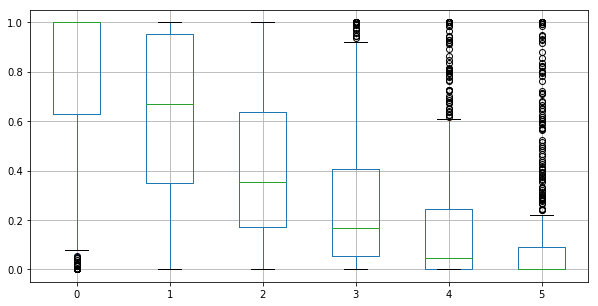

In [41]:
df_liq_train = df_train_temp[['Скважина','month', 'liq_rate']].set_index(['Скважина', 'month']).unstack(0).fillna(0)
df_liq_train.columns = df_liq_train.columns.droplevel(0)

liq_scaler = MinMaxScaler()
df_liq_train_norm = pd.DataFrame(liq_scaler.fit(df_liq_train.values).transform(df_liq_train.values), 
                                 index = df_liq_train.index, columns = df_liq_train.columns)
%matplotlib inline
plt.figure(figsize=(10,5))

df_liq_train_norm.T.boxplot()

### Дни работы скважины по месяцам. Видно, что в первом месяце работают в среднем по пол месяца, а дальше уже почти все дни

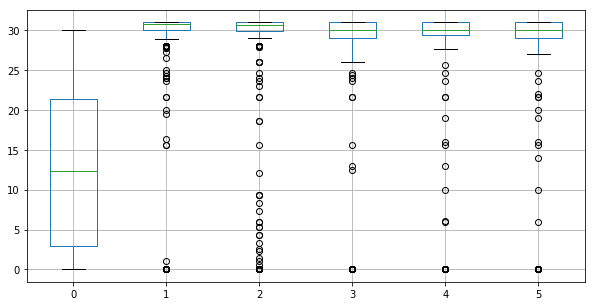

In [42]:
df_days_train = df_train_temp[['Скважина','month', 'days_on']].set_index(['Скважина', 'month']).unstack(0).fillna(0)
df_days_train.columns = df_days_train.columns.droplevel(0)
mean_days_on = df_days_train[df_days_train>5].mean(axis = 1).values
%matplotlib inline
plt.figure(figsize=(10,5))
df_days_train.T.boxplot()

### Падение по дебиту нефти

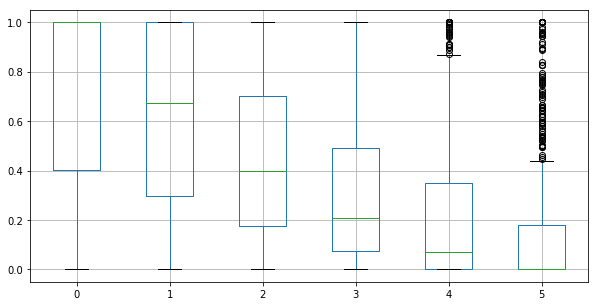

In [43]:
df_oil_train = df_train_temp[['Скважина','month', 'oil_rate']].set_index(['Скважина', 'month']).unstack(0).fillna(0)
df_oil_train.columns = df_oil_train.columns.droplevel(0)
oil_scaler = MinMaxScaler()
df_oil_train_norm = pd.DataFrame(oil_scaler.fit(df_oil_train.values).transform(df_oil_train.values), 
                                 index = df_oil_train.index, columns = df_oil_train.columns)
plt.figure(figsize=(10,5))
df_oil_train_norm.T.boxplot()

In [49]:
df_liq_train.columns[df_liq_train.isnull().all(0)]

Index([], dtype='object', name='Скважина')

### Распределение добычи нефти по месяцам

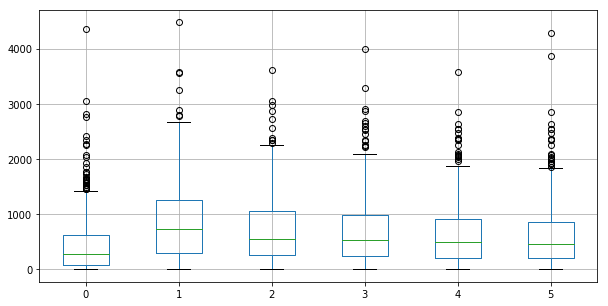

In [50]:
df_oil_prod_train = df_train_temp[['Скважина','month', 'oil_prod']].set_index(['Скважина', 'month']).unstack(0)#.fillna(0)
df_oil_prod_train.columns = df_oil_prod_train.columns.droplevel(0)
plt.figure(figsize=(10,5))
df_oil_prod_train.T.boxplot()

In [ ]:
df_oil_prod_train.loc[0,:].mean()

### Вычислим среднее падение дебита по месяцам

In [51]:
oil_rate_decline = df_oil_train_norm.mean(axis= 1).values

In [ ]:
x = df_train_temp['gas_prod'].values.astype(np.float64)[:, np.newaxis]
y = df_train_temp['oil_prod'].values.astype(np.float64)[:, np.newaxis]
angle = y / (x + 1)

plt.figure(figsize=(10, 8))
plt.scatter(x, y)

Загрузка прогноза стартовой добычи

In [53]:
df_start_oil_pred = pd.read_csv('./out/start_oil.csv')

df_start_oil_pred.columns = ['Скважина', 'oil_pred']

df_test_temp = pd.concat([df_test.set_index('Скважина'),df_start_oil_pred.set_index('Скважина')], axis= 1).reset_index()

df_test_temp.loc[df_test_temp['Состояние'] == 'ОСВ ТГ', 'oil_pred'] = 0
#df_test_temp.loc[df_test_temp['Состояние'] == 'ОСТ.', 'oil_pred'] = 0


wells_1 = df_test_temp.loc[df_test_temp['Состояние'] == 'ОСВ ТГ', 'Скважина'].tolist()
wells_0 = list(set(df_test_temp['Скважина'].tolist()) - set(wells_1))


df_test_temp['month'] = 0

In [55]:
df_test_temp['days_on'] = 0
df_test_temp.loc[df_test_temp['Скважина'].isin(wells_0), 'days_on'] = \
        (df_test_temp.loc[df_test_temp['Скважина'].isin(wells_0),'Время работы, ч']/24).fillna(mean_days_on[0])
#df_test_temp.loc[df_test_temp['Скважина'].isin(wells_1), 'days_on'] = mean_days_on

In [57]:
df_test_temp['pred_oil_rate'] = (df_test_temp['oil_pred'] / df_test_temp['days_on']).fillna(0)

df_test_pred_rate = df_test_temp[['Скважина','month', 'pred_oil_rate']].set_index(['Скважина', 'month']).unstack(0)

df_test_pred_rate.columns = df_test_pred_rate.columns.droplevel(0)

df_test_pred_rate = pd.concat([df_test_pred_rate, 
                                              pd.DataFrame(np.zeros((5, df_test_pred_rate.shape[1])), 
                                                           index = range(1,6),
                                                          columns = df_test_pred_rate.columns)])

In [58]:
df_test_pred_rate.loc[1, wells_1] = df_start_oil_pred.loc[df_start_oil_pred['Скважина'].isin(wells_1), 'oil_pred'].values/mean_days_on[0]

In [59]:
for i in range(2,6):
    df_test_pred_rate.loc[i, wells_1] = df_test_pred_rate.loc[1, wells_1]*oil_rate_decline[i-1]

In [60]:
for i in range(1,6):
    df_test_pred_rate.loc[i, wells_0] = df_test_pred_rate.loc[0, wells_0]*oil_rate_decline[i]

In [61]:
df_test_pred_prod = df_test_pred_rate.copy()

In [62]:
df_test_pred_prod.loc[0, :] = df_test_pred_rate.loc[0, :]*df_test_temp['days_on'].values

In [63]:
df_test_pred_prod.loc[1, wells_1] = df_test_pred_rate.loc[1, wells_1].values * mean_days_on[0]

In [64]:
for i in range (2,6):
    df_test_pred_prod.loc[i, wells_1] = df_test_pred_rate.loc[i, wells_1].values * mean_days_on[i]
for i in range(1,6):
    df_test_pred_prod.loc[i, wells_0] = df_test_pred_rate.loc[i, wells_0].values * mean_days_on[i]

In [ ]:
df_test_final_pred = pd.DataFrame(df_test_pred_prod.values.T.reshape(-1,1))

df_test_final_pred.to_csv('./out/subm.csv')

In [ ]:
df_test_final_pred